In [2]:
import pandas as pd
import numpy as np
import pathlib as pl
import sklearn
import pathlib as pl

In [3]:
dictionarypath = '../dataset/dictionary/Loughran-McDonald_MasterDictionary_1993-2021.csv'
wds_dict = pd.read_csv(dictionarypath)
positive_wds = [row['Word'].lower() for i, row in wds_dict.iterrows() if row['Positive']!=0]
negative_wds = [row['Word'].lower() for i, row in wds_dict.iterrows() if row['Negative']!=0]

In [5]:
# path = '../dataset/finRep/FinancialPhraseBank/all-data.csv'
# df = pd.read_csv(path, encoding = "ISO-8859-1", names = ['sentiment', 'sentence'])
# # print(df[:10])
path = '../dataset/finRep/FiQA/fiqa_extended.csv'
df = pd.read_csv(path, encoding = "ISO-8859-1")

df['sentiment_score'] = np.where((df['sentiment_score'] < 0.35 ) & (df['sentiment_score'] > -0.35), 0, df['sentiment_score'])
df['sentiment_score'] = np.where((df['sentiment_score'] >= 0.35 ), 1, df['sentiment_score'])
df['sentiment_score'] = np.where((df['sentiment_score'] <= -0.35 ), -1, df['sentiment_score'])
df['sentiment_score'] = df['sentiment_score'].astype(int)
df

,title,body,links,source,target,sentiment_score
0,Dairy Crest loses a third of Morrisons milk co...,(Reuters) - Dairy Crest Group Plc DCG.L lost a...,https://www.reuters.com/article/uk-dairy-crest...,www.reuters.com,Morrisons,0
1,Pearson expects to return to growth this year,LONDON (Reuters) - Pearson PSON.L said it expe...,https://www.reuters.com/article/uk-pearson-res...,www.reuters.com,Pearson,1
2,"FDA approves NPS drug, in move validating Shir...",Jan 23 (Reuters) - The U.S. Food and Drug Admi...,https://www.reuters.com/article/fda-nps-pharma...,www.reuters.com,Shire,0
3,Shire to buy NPS for $5.2 billion to boost rar...,LONDON (Reuters) - Shire Plc has agreed to buy...,https://www.reuters.com/article/us-nps-m-a-shi...,www.reuters.com,Shire,0
4,"UPDATE 1-Just the ticket, Trainline shares sur...",* Trainline valued at 1.68 bln pounds in Londo...,https://www.reuters.com/article/trainline-list...,www.reuters.com,Thetrainline.com,0
...,...,...,...,...,...,...
197,U.K. Stocks Little Changed as Barclays Gain Of...,\nU.K. stocks were little changed as gains in ...,https://www.bloomberg.com/news/articles/2014-1...,www.bloomberg.com,Shell,-1
198,ShellÂs $70 billion BG deal meets shareholder...,\nLondon/New Delhi: The biggest deal in Royal ...,https://www.livemint.com/Companies/TyrP7qjLuKn...,www.livemint.com,Shell,0
199,City spirits sink after Diageo comes up short ...,Hopes of a sales rebound at Diageo at the star...,https://www.independent.co.uk/news/business/ne...,www.independent.co.uk,Diageo,-1
200,Diageo receives reports from United Spirits on...,MUMBAI: British drinks major Diageo Â also th...,https://m.economictimes.com/industry/cons-prod...,m.economictimes.com,Diageo,0


-1     33
 1     57
 0    112
Name: sentiment_score, dtype: int64

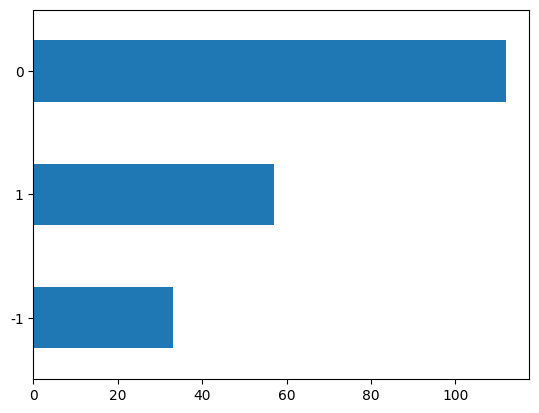

In [6]:
df.sentiment_score.value_counts().sort_values().plot(kind = 'barh')
df.sentiment_score.value_counts().sort_values()

In [47]:
# to install keybert
# !pip install nltk
# !pip install keybert
# !pip install sentence-transformers
# !pip install git+https://github.com/LIAAD/yake
### To show the execution times
# !pip install ipython-autotime
# %load_ext autotime

In [7]:
import re

text = df.sample(1).iloc[0]['body']
text = re.sub(r'[^A-Za-z0-9 .,;]+', '', text)
text = re.sub(' +', ' ', text)
# df =df.drop(index = 0)
    # df[:3]
print(text)
label = df.sample(1)['sentiment_score'].iloc[0]

print("the sentiment is : %s"%label)

MANCHESTER, N.H. Reuters New Hampshires top court on Friday upheld a 236 million judgment against Exxon Mobil Corp over groundwater contamination linked to gasoline additive MTBE.The New Hampshire Supreme Court ruling affirms a 2013 jury decision that rejected Exxons claims that contamination linked to the fuel additive was the fault of the local gas stations and storage facilities that spilled it.In the 1990s, in response to U.S. clean air regulations, MTBE was commonly added to gasoline to reduce smog. Subsequent studies found that the chemical easily penetrated and contaminated groundwater, and its use was gradually phased out.New Hampshires lawsuit against Exxon, which is headquartered in Irving, Texas, dates back to 2003. State officials say the 236.3 million judgment is the largest MTBE verdict since states and other agencies began making the claims for remediation and other damages.This is the most significant environmental victory in the history of the state, New Hampshire Atto

In [8]:
def normalize_keyword_list(keyword_list):
    keys = []
    for keyword in keyword_list:
        keys.append(keyword[0])
    return keys

Rake

In [9]:
from rake_nltk import Rake
rake_nltk_var = Rake()

rake_nltk_var.extract_keywords_from_text(text)
rake_keywords = rake_nltk_var.get_ranked_phrases()
print(rake_keywords)

['new hampshire attorney general joseph foster said', 'new hampshire supreme court ruling affirms', 'largest mtbe verdict since states', 'reuters new hampshires top court', '105 million jury verdict', 'spokesman todd spitler said', 'new hampshires lawsuit', 'new hampshire officials', 'new york city', 'received 90 million', '3 million judgment', '2013 jury decision', 'significant environmental victory', 'local gas stations', 'clean air regulations', 'chemical easily penetrated', 'agencies began making', 'historic decision sends', '236 million judgment', 'subsequent studies found', 'rejected exxons claims', 'exxon mobil corp', 'state officials say', 'groundwater contamination linked', 'new hampshire', 'new hampshire', 'new hampshire', 'new hampshire', 'someone spilled gasoline', 'supreme court', 'supreme court', 'gasoline additive mtbe', 'court declined', 'exxon said', 'contamination linked', 'decision stand', 'fuel additive', 'mtbe contamination', 'mtbe contamination', 'mtbe contaminati

In [10]:
# Import them
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
sent_trans = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
keyBERT_model = KeyBERT(model = sent_trans)

c:\Users\Rolando\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def extract_terms(document, n_gram_range = (3,3), 
                  top_N=5, model=keyBERT_model, diversity_threshold = 0.7):

  keywords = model.extract_keywords(document, stop_words='english', 
                                    keyphrase_ngram_range=(1, 3),
                                    use_mmr=True, 
                                    diversity = diversity_threshold,
                                    top_n = top_N)
  
  return sorted(keywords, key=lambda tup:(-tup[1], tup[0]))

In [12]:
# print(f'Text: {text}.\nLength: {len(text.split())}')
keybert_keywords = extract_terms(text)
keybert_keywords = normalize_keyword_list(keybert_keywords)

print(keybert_keywords)

['hampshires lawsuit exxon', 'mtbe commonly added', 'reduce smog subsequent', 'additive fault local', 'new york city']


In [13]:
import yake
kw_extractor = yake.KeywordExtractor()
yake_keywords = kw_extractor.extract_keywords(text)
yake_keywords = normalize_keyword_list(yake_keywords)

print(yake_keywords)


# print("SECOND FORM:")
# language = "en"
# max_ngram_size = 3
# deduplication_threshold = 0.9
# deduplication_algo = 'seqm'
# windowSize = 1
# numOfKeywords = 20

# custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
# keywords = custom_kw_extractor.extract_keywords(text)

# for kw in keywords:
#     print(kw)

['Exxon Mobil Corp', 'Hampshire Supreme Court', 'Hampshires top court', 'Mobil Corp', 'clean air regulations', 'gasoline additive MTBE.The', 'local gas stations', 'Supreme Court ruling', 'Court ruling affirms', 'groundwater contamination linked', 'rejected Exxons claims', 'Hampshire Attorney General', 'Exxon Mobil', 'Reuters New Hampshires', 'contamination linked', 'Hampshire', 'Supreme Court', 'Hampshire Supreme', 'Hampshires top', 'MTBE contamination']


In [14]:
Keywords = {}
Keywords["rake"] = rake_keywords
Keywords["keybert"] = keybert_keywords
Keywords["yake"] = yake_keywords
print("Rake: %s" % Keywords["rake"]) 
print("Keybert: %s" % Keywords["keybert"]) 
print("Yake: %s" % Keywords["yake"]) 

Rake: ['new hampshire attorney general joseph foster said', 'new hampshire supreme court ruling affirms', 'largest mtbe verdict since states', 'reuters new hampshires top court', '105 million jury verdict', 'spokesman todd spitler said', 'new hampshires lawsuit', 'new hampshire officials', 'new york city', 'received 90 million', '3 million judgment', '2013 jury decision', 'significant environmental victory', 'local gas stations', 'clean air regulations', 'chemical easily penetrated', 'agencies began making', 'historic decision sends', '236 million judgment', 'subsequent studies found', 'rejected exxons claims', 'exxon mobil corp', 'state officials say', 'groundwater contamination linked', 'new hampshire', 'new hampshire', 'new hampshire', 'new hampshire', 'someone spilled gasoline', 'supreme court', 'supreme court', 'gasoline additive mtbe', 'court declined', 'exxon said', 'contamination linked', 'decision stand', 'fuel additive', 'mtbe contamination', 'mtbe contamination', 'mtbe conta

NLTK-VADER

In [15]:
print(keybert_keywords)

['hampshires lawsuit exxon', 'mtbe commonly added', 'reduce smog subsequent', 'additive fault local', 'new york city']


In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

result = []
for sentence in keybert_keywords:
    s = sentence.split()
    keyword_sen = []
    for word in s:
        if (sid.polarity_scores(word)['compound']) >= 0.5:
            keyword_sen.append(tuple((word, 1)))
        elif (sid.polarity_scores(word)['compound']) <= -0.5:
            keyword_sen.append(tuple((word, -1)))
        else:
            keyword_sen.append(tuple((word, 0)))
    result.append(keyword_sen)

print(result)              

[[('hampshires', 0), ('lawsuit', 0), ('exxon', 0)], [('mtbe', 0), ('commonly', 0), ('added', 0)], [('reduce', 0), ('smog', 0), ('subsequent', 0)], [('additive', 0), ('fault', 0), ('local', 0)], [('new', 0), ('york', 0), ('city', 0)]]


Using TextBlob

In [17]:
from textblob import TextBlob

result = []
for sentence in keybert_keywords:
    s = sentence.split()
    keyword_sen = []
    for word in s:
        testimonial = TextBlob(word)
        if testimonial.sentiment.polarity >= 0.5:
            keyword_sen.append(tuple((word, 1)))
        elif testimonial.sentiment.polarity <= -0.5:
            keyword_sen.append(tuple((word, -1)))
        else:
            keyword_sen.append(tuple((word, 0)))
    result.append(keyword_sen)
print(result)


[[('hampshires', 0), ('lawsuit', 0), ('exxon', 0)], [('mtbe', 0), ('commonly', 0), ('added', 0)], [('reduce', 0), ('smog', 0), ('subsequent', 0)], [('additive', 0), ('fault', 0), ('local', 0)], [('new', 0), ('york', 0), ('city', 0)]]


Using dictionary

In [18]:
def compare_words(keyword_list):
    result = []
    for sentence in keyword_list:
        words = sentence.split()
        keyword_sen = []
        for word in words:
            if word in positive_wds:
                keyword_sen.append(tuple((word, 1)))
            elif word in negative_wds:
                keyword_sen.append(tuple((word, -1)))
            else:
                keyword_sen.append(tuple((word, 0)))
        result.append(keyword_sen)
    return result

In [19]:
keybert_sen = compare_words(keybert_keywords) #keybert

print(keybert_sen)

[[('hampshires', 0), ('lawsuit', 0), ('exxon', 0)], [('mtbe', 0), ('commonly', 0), ('added', 0)], [('reduce', 0), ('smog', 0), ('subsequent', 0)], [('additive', 0), ('fault', -1), ('local', 0)], [('new', 0), ('york', 0), ('city', 0)]]


In [23]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')
FinalKeys = []
for keybert in Keywords["keybert"]:
    word1 = nlp(keybert)
    for rake in Keywords["rake"]:
        word2 = nlp(rake)
        for yake in Keywords["yake"]:
            word3 = nlp(yake)
            if word3.similarity(word1) > 0.7 and (not(keybert in FinalKeys)):
                FinalKeys.append(keybert)
            if word3.similarity(word2) > 0.7 and not(rake in FinalKeys):
                FinalKeys.append(rake)
            if word2.similarity(word1) > 0.7 and not(keybert in FinalKeys):
                FinalKeys.append(keybert)
print(FinalKeys)

C:\Users\Rolando\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rolando\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with

['new hampshire attorney general joseph foster said', 'new hampshire supreme court ruling affirms', 'reuters new hampshires top court', 'new hampshire officials', 'new york city', 'local gas stations', 'clean air regulations', 'rejected exxons claims', 'exxon mobil corp', 'groundwater contamination linked', 'new hampshire', 'supreme court', 'gasoline additive mtbe', 'contamination linked', 'mtbe contamination', 'storage facilities', 'natural resources', 'legal settlements', 'mtbe commonly added', 'reduce smog subsequent']


PREPROCESSING